## **Connecting to MyDrive to access Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Extracting the Dataset**

In [2]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/ToothNumber_TaskDataset.zip"
extract_path = "/content/dental_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))

['images', 'labels']


## **Splitting into Train, Test, Val**

In [3]:
import glob
import shutil
import random

# Input folders
img_dir = os.path.join(extract_path, "images")
lbl_dir = os.path.join(extract_path, "labels")

# Output structure
out_dir = "/content/dental_dataset_split"
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(out_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(out_dir, split, "labels"), exist_ok=True)

# Get all images
images = glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.png"))
images.sort()

# Shuffle for random split
random.seed(42)
random.shuffle(images)

# Split sizes
n_total = len(images)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

train_files = images[:n_train]
val_files = images[n_train:n_train+n_val]
test_files = images[n_train+n_val:]

def move_files(file_list, split):
    for img_path in file_list:
        fname = os.path.basename(img_path)
        label_path = os.path.join(lbl_dir, fname.replace(".jpg", ".txt").replace(".png", ".txt"))

        # Copy image
        shutil.copy(img_path, os.path.join(out_dir, split, "images", fname))
        # Copy label (if exists)
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(out_dir, split, "labels", os.path.basename(label_path)))

# Move files
move_files(train_files, "train")
move_files(val_files, "val")
move_files(test_files, "test")

print(f"Total images: {n_total}")
print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Total images: 497
Train: 397, Val: 49, Test: 51


## **Creating data.yaml**

In [4]:
data_yaml = """
train: /content/dental_dataset_split/train/images
val: /content/dental_dataset_split/val/images
test: /content/dental_dataset_split/test/images

names:
  0: Canine (13)
  1: Canine (23)
  2: Canine (33)
  3: Canine (43)
  4: Central Incisor (21)
  5: Central Incisor (41)
  6: Central Incisor (31)
  7: Central Incisor (11)
  8: First Molar (16)
  9: First Molar (26)
  10: First Molar (36)
  11: First Molar (46)
  12: First Premolar (14)
  13: First Premolar (34)
  14: First Premolar (44)
  15: First Premolar (24)
  16: Lateral Incisor (22)
  17: Lateral Incisor (32)
  18: Lateral Incisor (42)
  19: Lateral Incisor (12)
  20: Second Molar (17)
  21: Second Molar (27)
  22: Second Molar (37)
  23: Second Molar (47)
  24: Second Premolar (15)
  25: Second Premolar (25)
  26: Second Premolar (35)
  27: Second Premolar (45)
  28: Third Molar (18)
  29: Third Molar (28)
  30: Third Molar (38)
  31: Third Molar (48)
"""

with open("/content/dental_dataset_split/data.yaml", "w") as f:
    f.write(data_yaml)

## **Install Ultralytics YOLO and Importing**

In [5]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.1 MB/s eta 0:00:00


In [6]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **Load Pre-trained weights and Train**

In [7]:
model = YOLO("yolov8s.pt")

results = model.train(
    data="/content/dental_dataset_split/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    workers=2,
    name="yolov8_dental_FDI"
)

Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dental_dataset_split/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_dental_FDI, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

## **Evaluation**

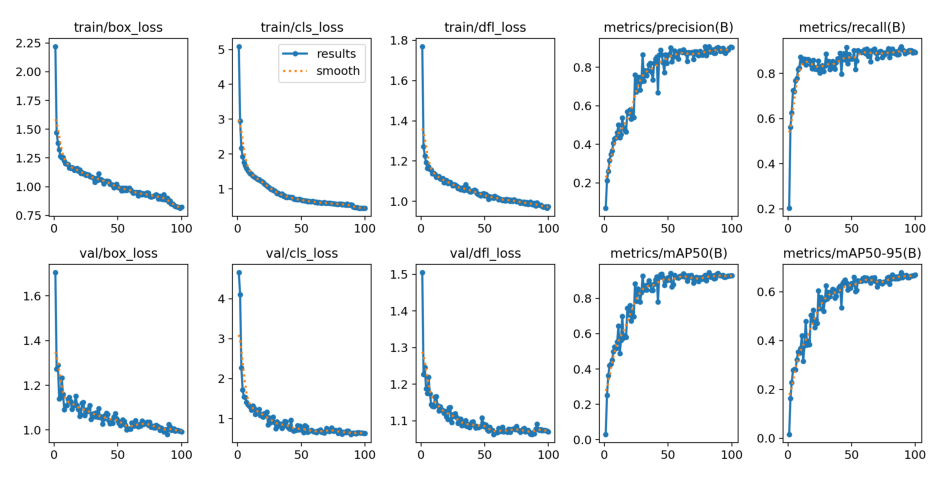

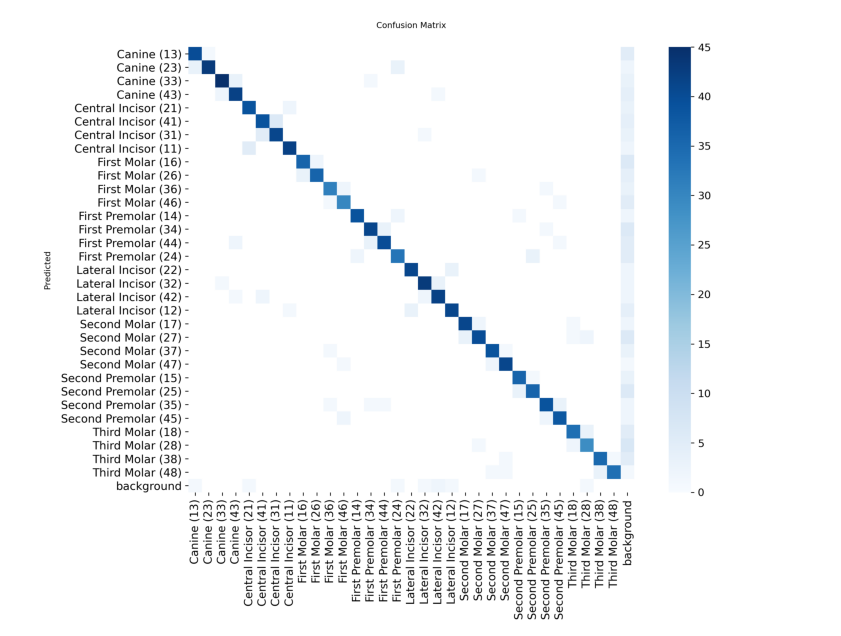

In [8]:
import matplotlib.pyplot as plt
import cv2

# Show training curves
img = cv2.imread("runs/detect/yolov8_dental_FDI/results.png")
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Show confusion matrix
img = cv2.imread("runs/detect/yolov8_dental_FDI/confusion_matrix.png")
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [11]:
from ultralytics import YOLO

# Load the trained model
model = YOLO("runs/detect/yolov8_dental_FDI/weights/best.pt")

# Evaluate on validation set
metrics = model.val()

print(metrics)

Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1462.6±559.6 MB/s, size: 72.2 KB)
val: Scanning /content/dental_dataset_split/val/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 49/49 7697.1it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.89it/s 4.5s
                   all         49       1353      0.903      0.919       0.94      0.679
           Canine (13)         44         44      0.897      0.932      0.938      0.708
           Canine (23)         44         44      0.953      0.977      0.948      0.662
           Canine (33)         48         48      0.918       0.93      0.929      0.667
           Canine (43)         48         48      0.914      0.887      0.877      0.614
  Central Incisor (21)         45      

## **Run the trained model on test images**

In [9]:
from ultralytics import YOLO

# Load best model
model = YOLO("runs/detect/yolov8_dental_FDI/weights/best.pt")

# Run inference on test set
results = model.predict(source="/content/dental_dataset_split/test/images", save=True, imgsz=640, conf=0.25)


image 1/51 /content/dental_dataset_split/test/images/05ff01fa-20250108-115407401.jpg: 640x640 1 Canine (13), 1 Canine (23), 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 1 Central Incisor (41), 1 Central Incisor (31), 1 Central Incisor (11), 1 First Molar (16), 1 First Molar (26), 1 First Molar (36), 1 First Molar (46), 1 First Premolar (14), 1 First Premolar (34), 1 First Premolar (44), 1 First Premolar (24), 1 Lateral Incisor (22), 1 Lateral Incisor (32), 1 Lateral Incisor (42), 1 Lateral Incisor (12), 1 Second Molar (17), 1 Second Molar (27), 1 Second Molar (37), 1 Second Molar (47), 1 Second Premolar (15), 1 Second Premolar (25), 1 Second Premolar (35), 1 Second Premolar (45), 1 Third Molar (18), 1 Third Molar (28), 1 Third Molar (38), 1 Third Molar (48), 16.3ms
image 2/51 /content/dental_dataset_split/test/images/124e696d-20240914-105651782.jpg: 640x640 1 Canine (13), 2 Canine (23)s, 1 Canine (33), 1 Central Incisor (21), 1 Central Incisor (41), 1 Central Incisor (31), 1 

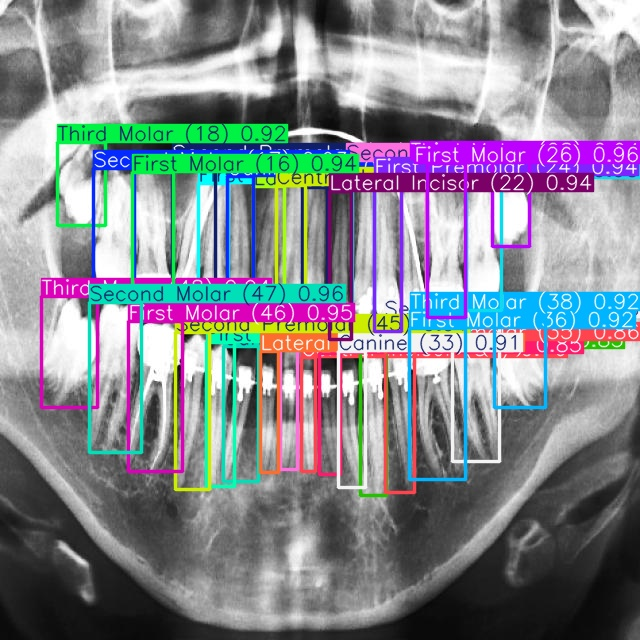

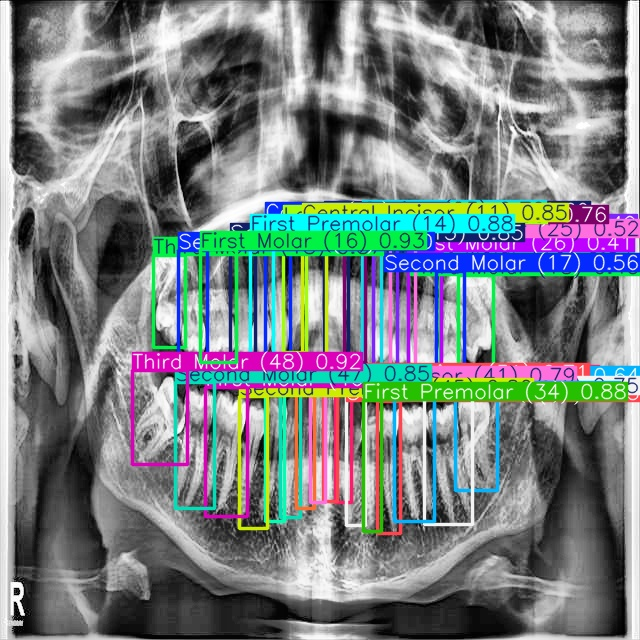

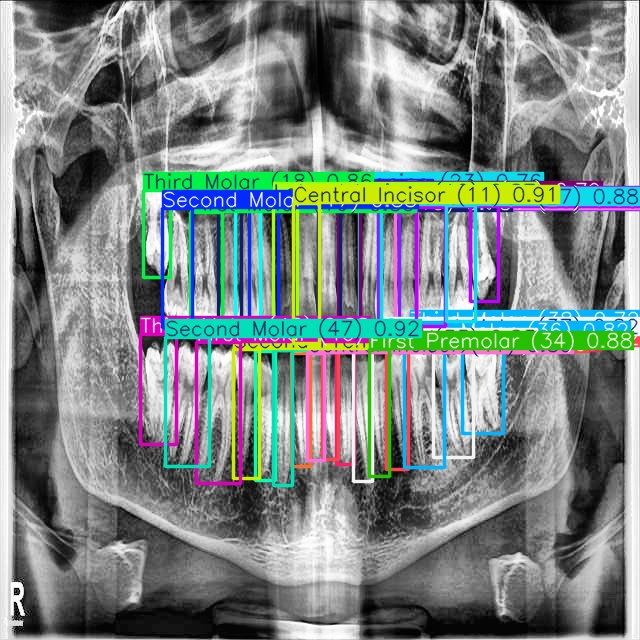

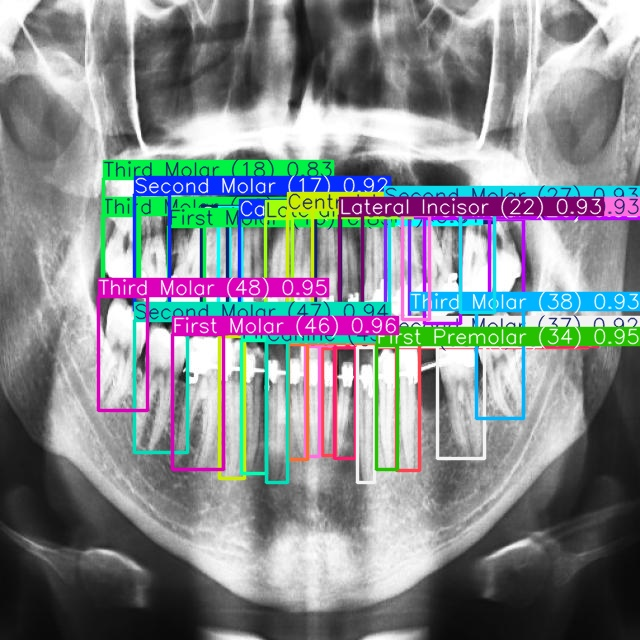

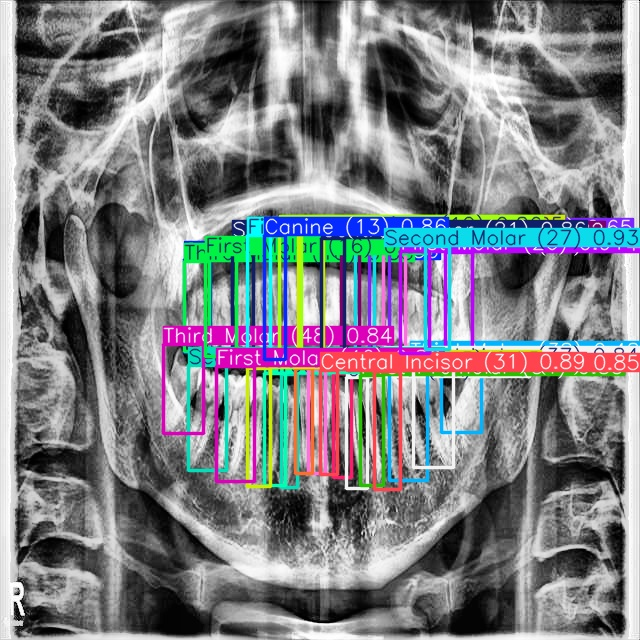

In [13]:
import glob
from IPython.display import Image, display

for image_path in glob.glob('runs/detect/predict/*.jpg')[:5]:
    display(Image(filename=image_path))

## **Post-processing Steps**
Apply FDI Numbering and handling missing teeth

In [25]:
import numpy as np

def post_process(predictions, img_shape):
    """
    Post-process YOLO predictions into FDI numbering with missing teeth detection.

    predictions: list of [x_center, y_center, w, h, conf, class_id]
    img_shape: (H, W) of image
    """
    H, W = img_shape
    mid_y = H // 2
    mid_x = W // 2

    upper, lower = [], []

    # Separate upper vs lower arch
    for pred in predictions:
        x, y, w, h, conf, cls = pred
        if y < mid_y:  # upper arch
            upper.append(pred)
        else:          # lower arch
            lower.append(pred)

    def process_quadrant(teeth, expected_numbers):
        """
        teeth: list of predictions in a quadrant
        expected_numbers: FDI numbers expected in this quadrant
        """
        # Sort by x-coordinate (left → right)
        teeth_sorted = sorted(teeth, key=lambda t: t[0])
        assigned = {}

        if not teeth_sorted:
            # All missing
            for num in expected_numbers:
                assigned[num] = None
            return assigned

        # Step 1: Assign sequentially
        for i, tooth in enumerate(teeth_sorted):
            if i < len(expected_numbers):
                assigned[expected_numbers[i]] = tooth

        # Step 2: Detect missing teeth using gap analysis
        x_centers = [t[0] for t in teeth_sorted]
        gaps = np.diff(x_centers)

        if len(gaps) > 0:
            avg_gap = np.mean(gaps)
            for i, g in enumerate(gaps):
                if g > 1.5 * avg_gap:
                    # Gap too wide → at least one missing tooth
                    missing_number = expected_numbers[i+1]
                    if missing_number not in assigned:
                        assigned[missing_number] = None  # Mark missing

        # Step 3: Fill unassigned numbers as missing
        for num in expected_numbers:
            if num not in assigned:
                assigned[num] = None

        return assigned

    # Split into quadrants
    upper_left  = [t for t in upper if t[0] < mid_x]
    upper_right = [t for t in upper if t[0] >= mid_x]
    lower_left  = [t for t in lower if t[0] < mid_x]
    lower_right = [t for t in lower if t[0] >= mid_x]

    # FDI numbering system
    fdi_upper_right = [11, 12, 13, 14, 15, 16, 17, 18]
    fdi_upper_left  = [21, 22, 23, 24, 25, 26, 27, 28]
    fdi_lower_left  = [31, 32, 33, 34, 35, 36, 37, 38]
    fdi_lower_right = [41, 42, 43, 44, 45, 46, 47, 48]

    # Assign FDI numbers with missing detection
    results = {
        "upper_right": process_quadrant(upper_right, fdi_upper_right),
        "upper_left": process_quadrant(upper_left, fdi_upper_left),
        "lower_left": process_quadrant(lower_left, fdi_lower_left),
        "lower_right": process_quadrant(lower_right, fdi_lower_right)
    }

    return results


## **Integrating post-processing and visualizing**

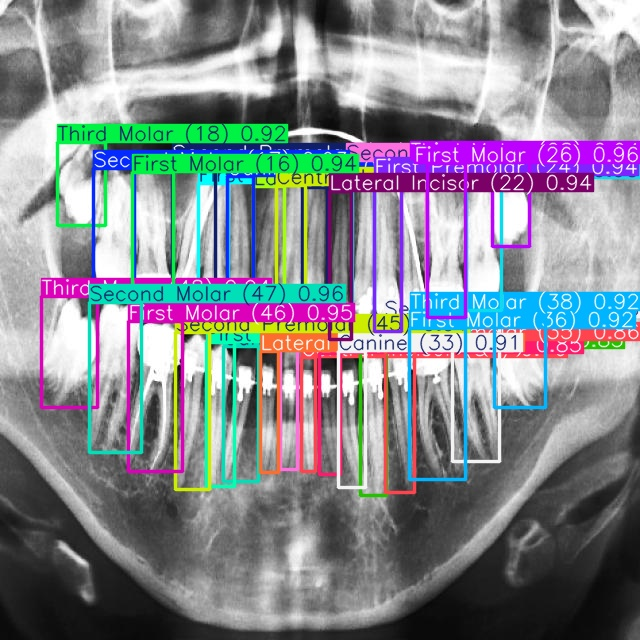

[WARN] No label file found for cate1-00068_jpg.rf.7053b967f1a29660587386e1dc0b8a99


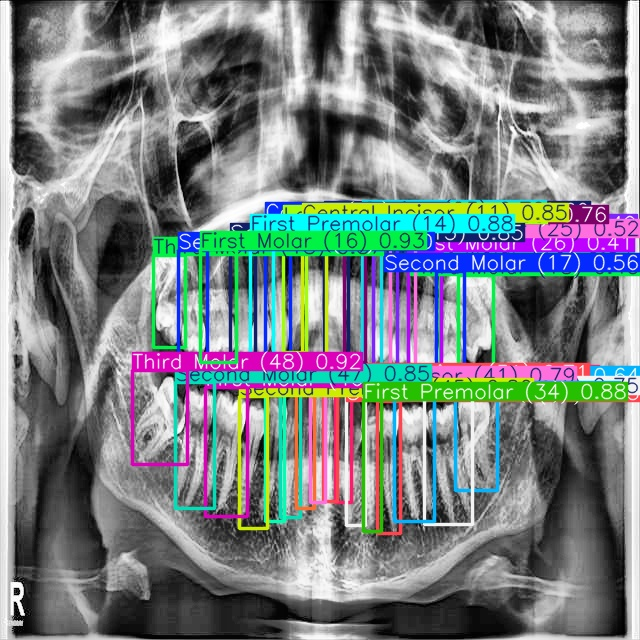

[WARN] No label file found for bd279a5f-20240920-115601588


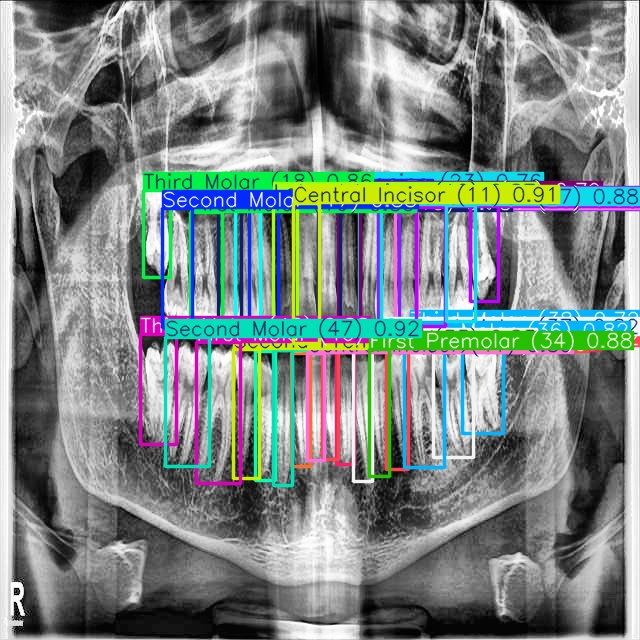

[WARN] No label file found for b94abb31-20250429-142751426


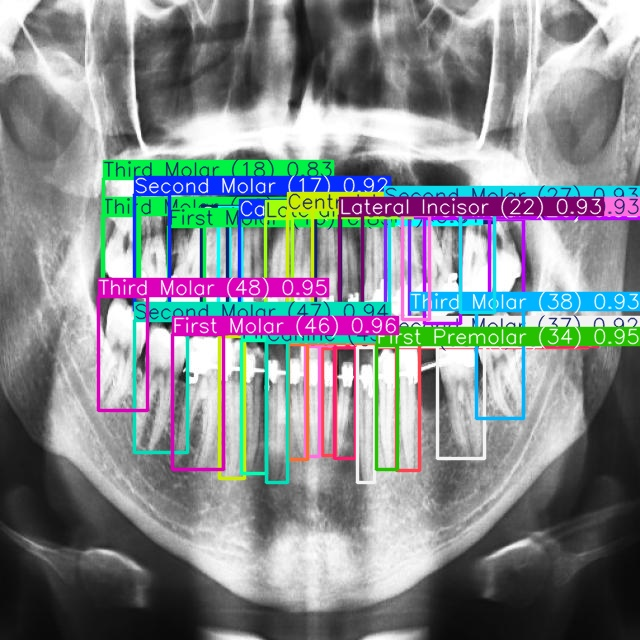

[WARN] No label file found for cate7-00018_jpg.rf.43b411df058815e8b08c6aa100710187


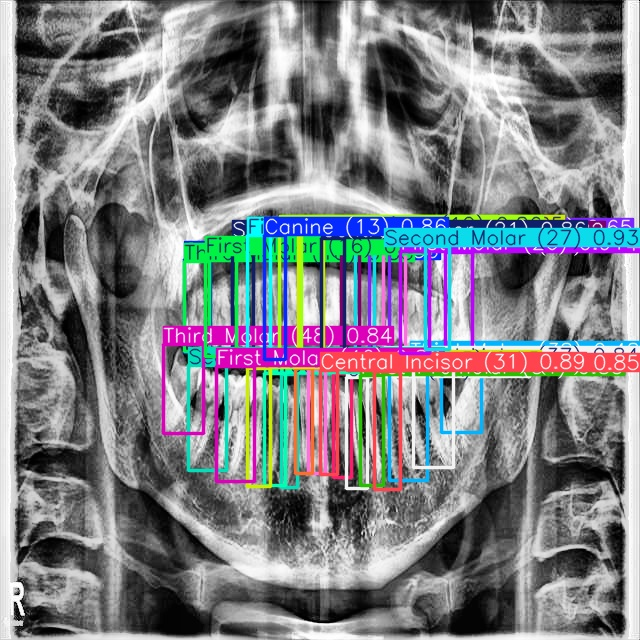

[WARN] No label file found for 1b000dc7-20240813-115604759


In [28]:
import os
import glob
import cv2
from IPython.display import Image, display

# ---------------------------
# 1. Load YOLO Predictions
# ---------------------------
def load_yolo_predictions(txt_file, img_shape):
    H, W = img_shape
    predictions = []
    with open(txt_file, "r") as f:
        for line in f.readlines():
            cls, x, y, w, h, conf = map(float, line.strip().split())
            # Convert normalized YOLO coords -> pixel coords
            x_c, y_c, w, h = x * W, y * H, w * W, h * H
            x1, y1 = int(x_c - w / 2), int(y_c - h / 2)
            x2, y2 = int(x_c + w / 2), int(y_c + h / 2)
            predictions.append([x1, y1, x2, y2, conf, int(cls)])
    return predictions


# ---------------------------
# 2. Post-Processing Function
# ---------------------------
def post_process(predictions, img_shape, conf_thresh=0.3):
    """
    Example post-processing:
    - Filter by confidence
    - Categorize into quadrants
    """
    H, W = img_shape
    results = {"Upper-Left": [], "Upper-Right": [], "Lower-Left": [], "Lower-Right": []}

    for (x1, y1, x2, y2, conf, cls) in predictions:
        if conf < conf_thresh:
            continue  # confidence filtering

        # Decide quadrant based on center point
        x_c, y_c = (x1 + x2) / 2, (y1 + y2) / 2
        if y_c < H / 2:  # Upper half
            if x_c < W / 2:
                results["Upper-Left"].append((x1, y1, x2, y2, conf, cls))
            else:
                results["Upper-Right"].append((x1, y1, x2, y2, conf, cls))
        else:  # Lower half
            if x_c < W / 2:
                results["Lower-Left"].append((x1, y1, x2, y2, conf, cls))
            else:
                results["Lower-Right"].append((x1, y1, x2, y2, conf, cls))

    return results


# ---------------------------
# 3. Iterate Through Results
# ---------------------------
for image_path in glob.glob('runs/detect/predict/*.jpg')[:5]:
    display(Image(filename=image_path))  # show raw image

    base = os.path.splitext(os.path.basename(image_path))[0]
    txt_path = f"runs/detect/predict/labels/{base}.txt"

    if os.path.exists(txt_path):
        img = cv2.imread(image_path)
        H, W = img.shape[:2]

        # (A) Load YOLO detections
        predictions = load_yolo_predictions(txt_path, (H, W))

        # (B) Apply Post-Processing
        results = post_process(predictions, (H, W))   # <-- integration point

        # (C) Draw final boxes
        for quadrant, teeth in results.items():
            for (x1, y1, x2, y2, conf, cls) in teeth:
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, f"Tooth {cls} ({quadrant})",
                            (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Save and show processed image
        save_path = f"runs/detect/processed/{base}_post.jpg"
        os.makedirs("runs/detect/processed", exist_ok=True)
        cv2.imwrite(save_path, img)
        display(Image(filename=save_path))

        # Print quadrant-wise tooth IDs
        print(f"\nImage: {base}")
        for quadrant, teeth in results.items():
            print(f"{quadrant}: {[t[-1] for t in teeth]}")

    else:
        print(f"[WARN] No label file found for {base}")